```
Regression Assignment
Gowlapalli Rohit 2021101113
```

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import bartlett
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

# PART 1

In [52]:
df = pd.read_csv("housing.csv")
counts = df['ocean_proximity'].value_counts()

#### We can see that ocean_proximity is having string variables. Lets convert it to numericals before we perform the correlation analysis

In [53]:
# cleaning the data by removing the nan values and changing data to numerical variables
df['ocean_proximity'] = df['ocean_proximity'].map({'<1H OCEAN':0, 'INLAND':1, 'NEAR OCEAN':2, 'NEAR BAY':3, 'ISLAND':4})
df = df.dropna()

## Visualize some correlations between variables in the data set

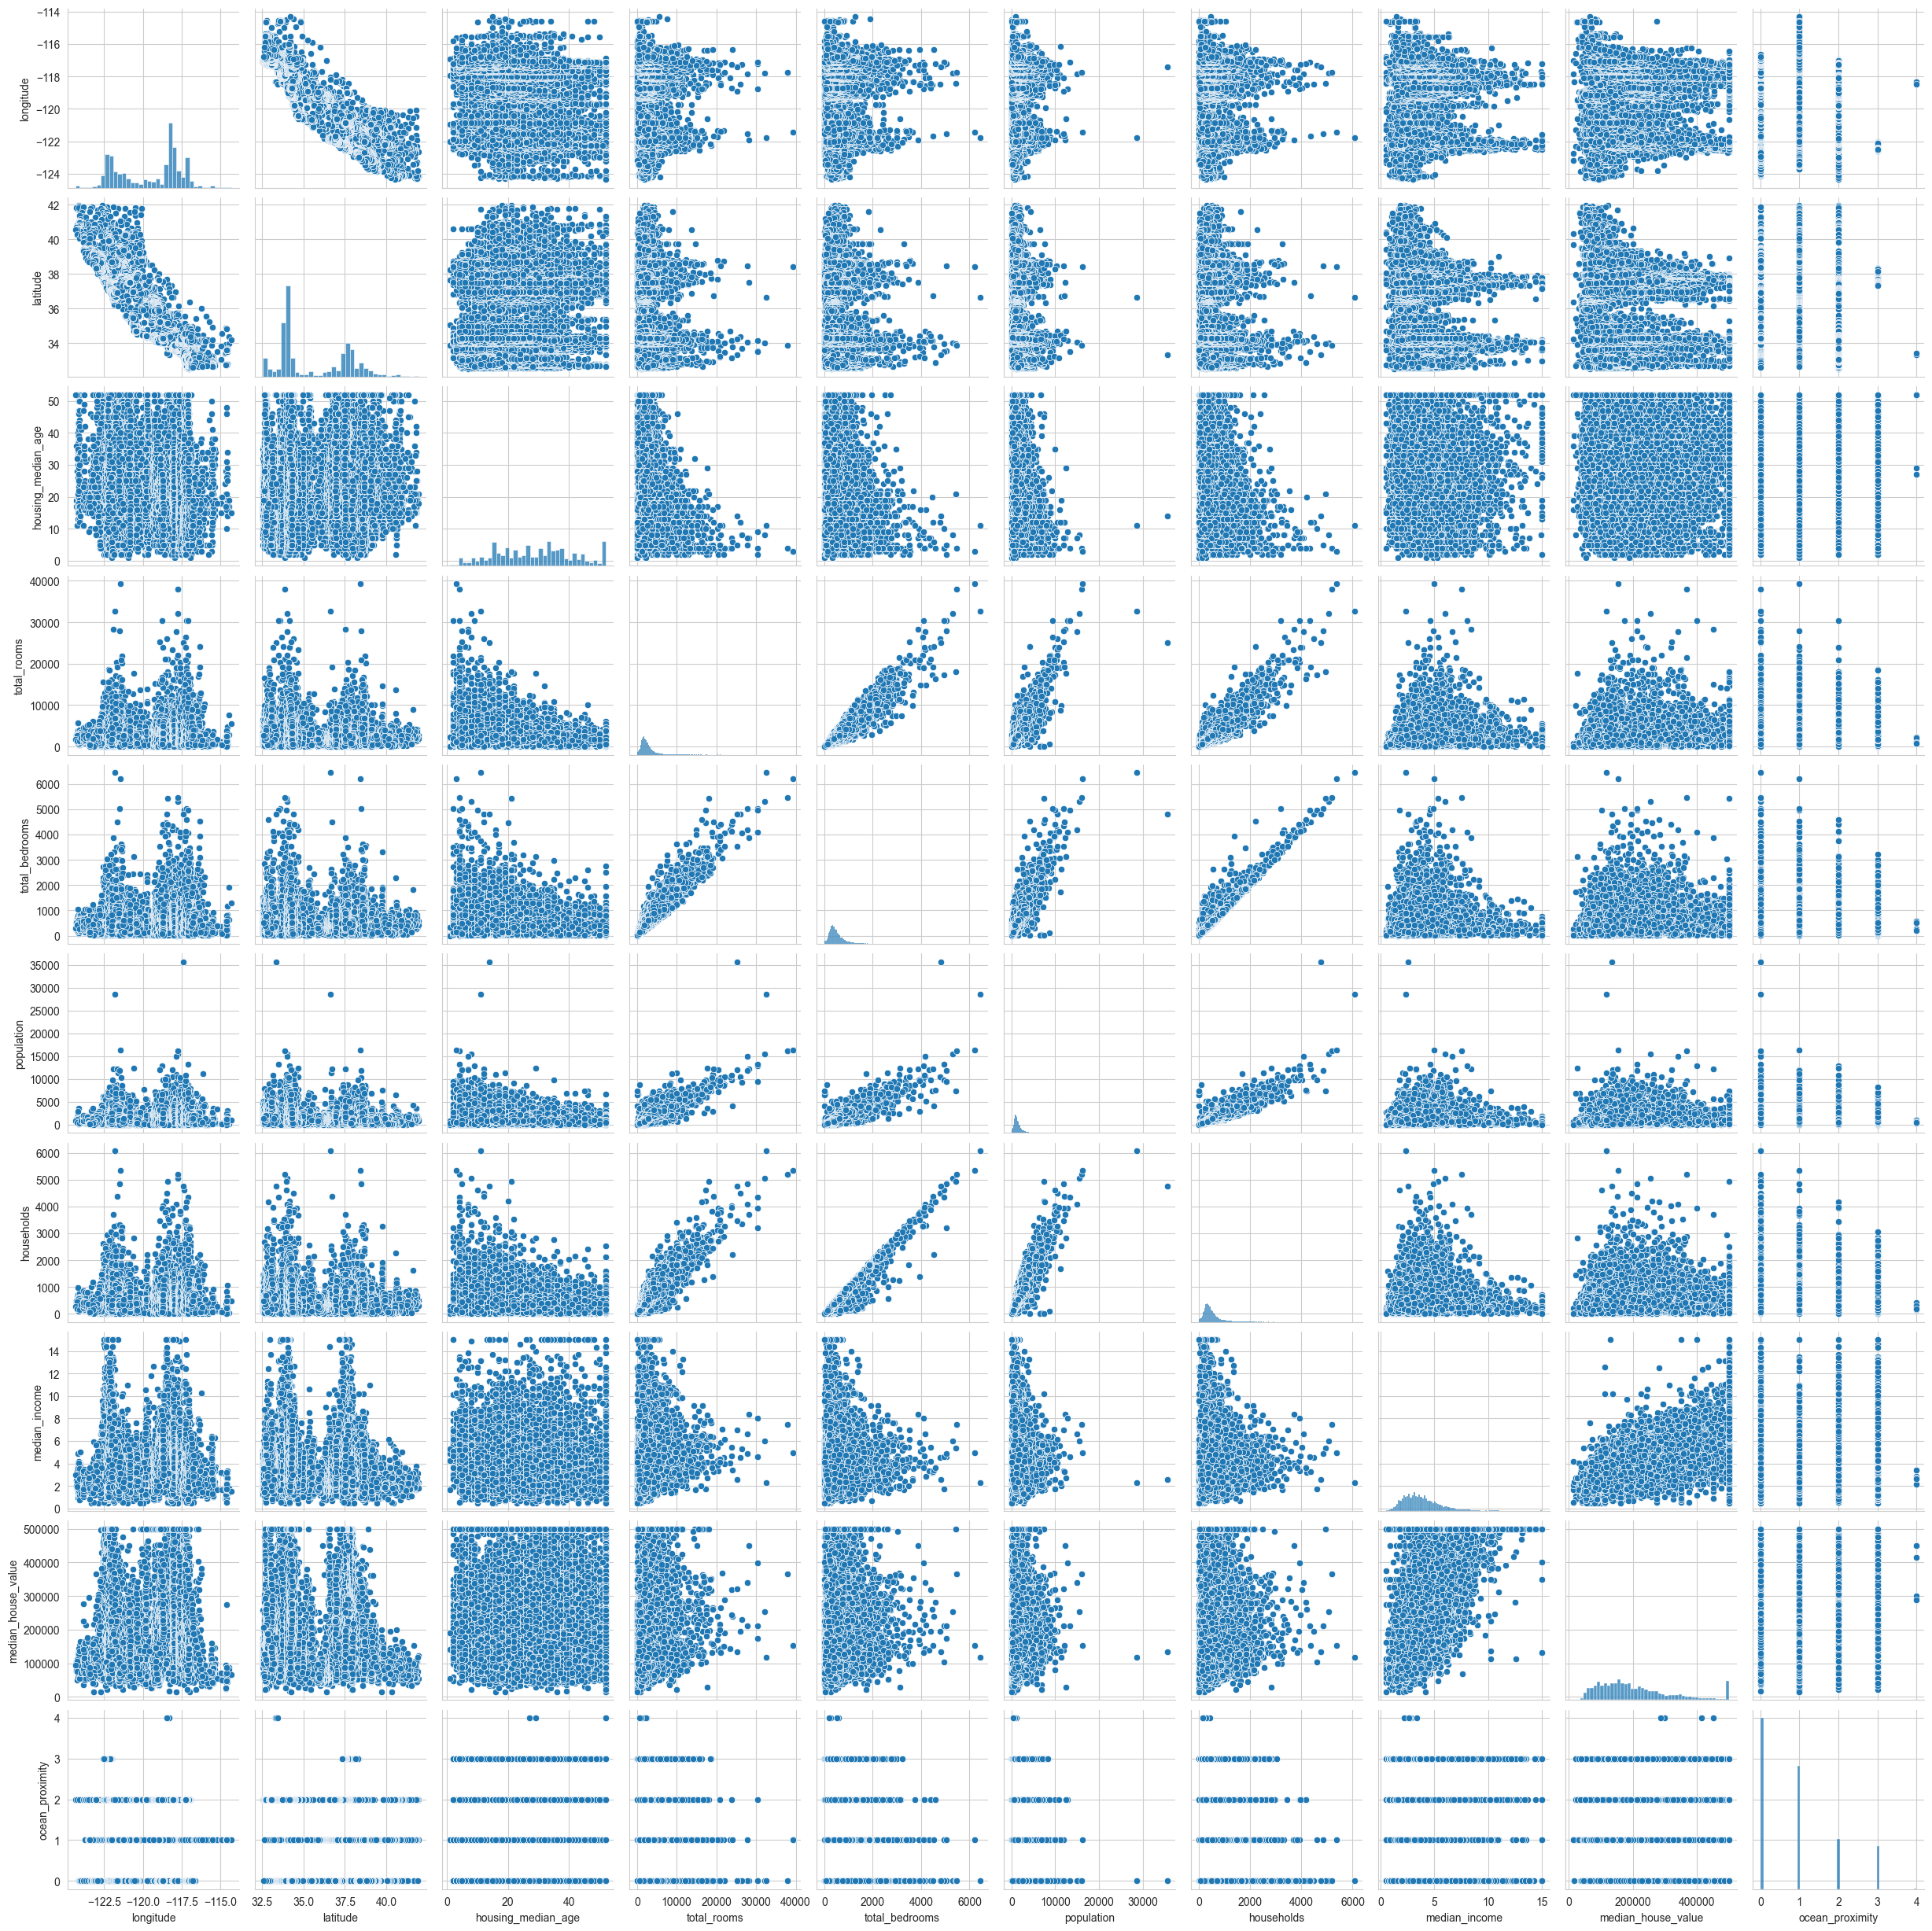

<Figure size 640x480 with 0 Axes>

In [54]:
sns.pairplot(df.dropna())
plt.show()
plt.tight_layout()

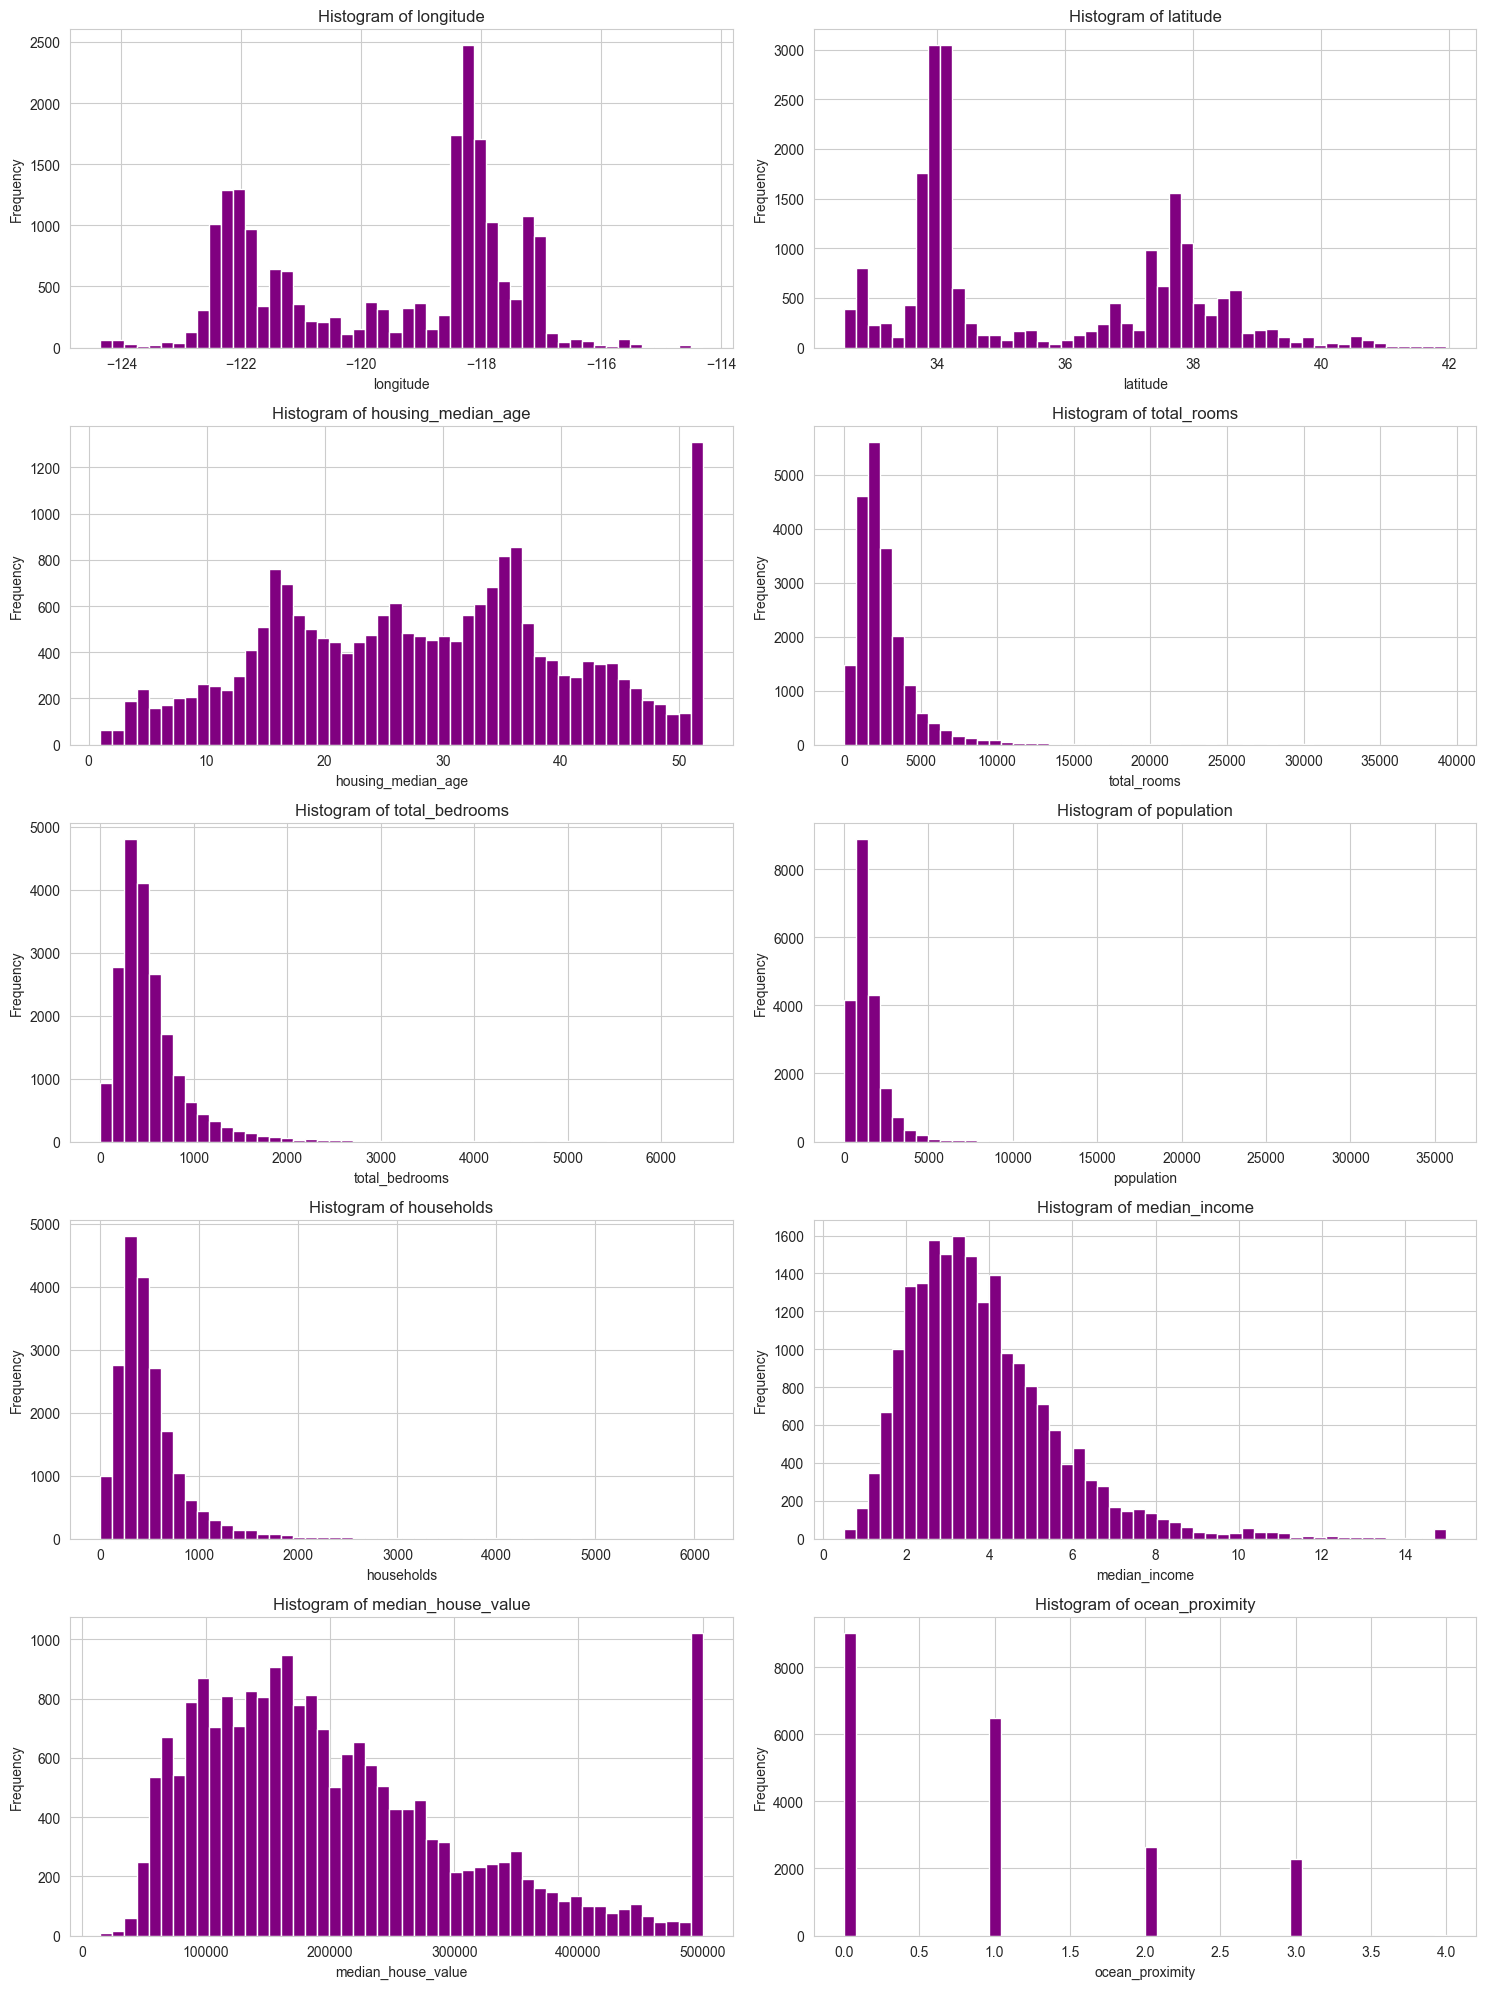

In [55]:
numeric_cols = df.columns
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
axes = axes.flatten()
for i, col_name in enumerate(numeric_cols):
    axes[i].hist(df[col_name], bins=50, color='purple')
    axes[i].set_title(f'Histogram of {col_name}')
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

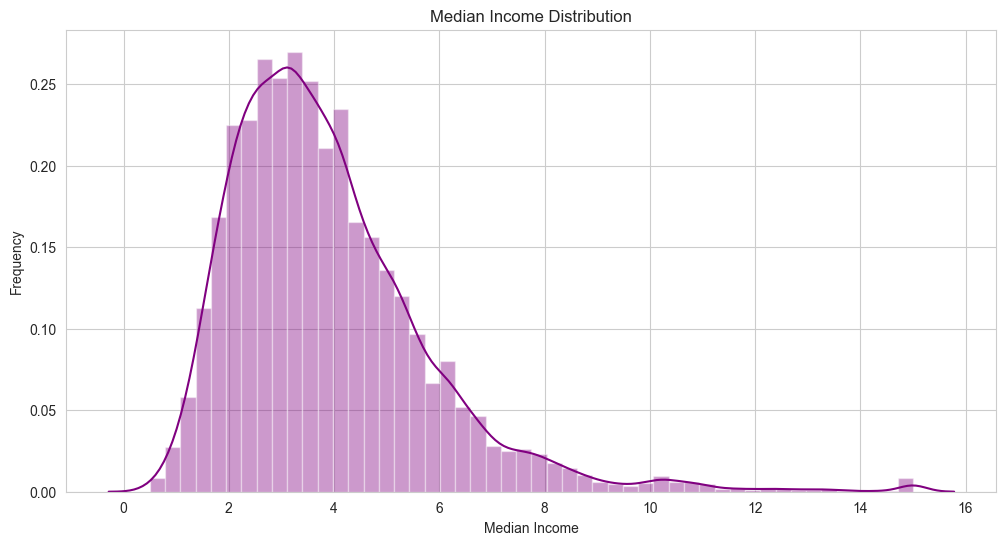

In [56]:
df_1 = df['median_income']
df_1 = np.array(pd.DataFrame(df_1, columns=['median_income'])).reshape(-1, 1)
y = df['median_house_value']
df_2 = df.copy()
df_2 = df_2.drop('median_house_value', axis=1)

plt.figure(figsize=(12, 6))
sns.distplot(df['median_income'], bins=50, color='purple')
plt.title('Median Income Distribution')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

<Axes: >

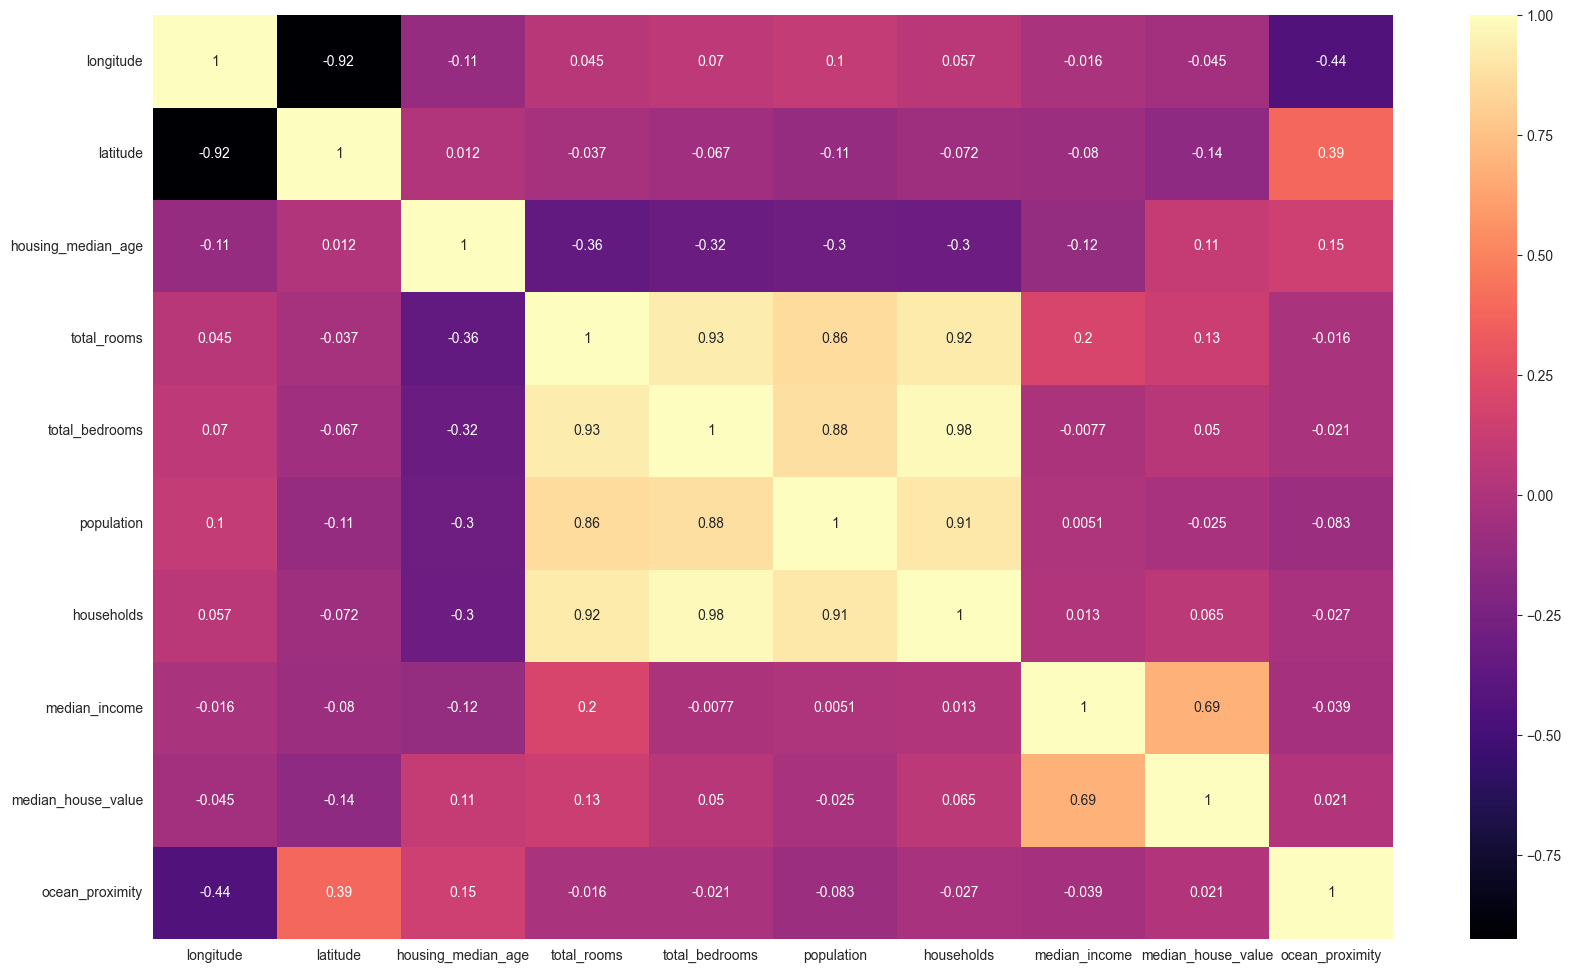

In [57]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap='magma')

#### We can clearly see some of the variables are highly correlated, now lets perform a correlation test to confirm the collinearity before building the model

In [58]:
def correlation_test(data1, data2, alternative):
    corr, p_value = pearsonr(data1, data2)
    print("Correlation coefficient:", corr)
    print("p-value:", p_value)
    print("Alternative hypothesis:", alternative)
    if alternative == "greater":
        if p_value/2 < 0.05:
            print("Reject the null hypothesis: There is a positive correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no positive correlation between the two variables")
    elif alternative == "less":
        if p_value/2 < 0.05:
            print("Reject the null hypothesis: There is a negative correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no negative correlation between the two variables")
    else:
        if p_value < 0.05:
            print("Reject the null hypothesis: There is a correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no correlation between the two variables")

print("Correlation test for total_bedrooms and total_rooms:")
correlation_test(df['total_bedrooms'], df['total_rooms'], alternative="greater")
print("\nCorrelation test for households and population:")
correlation_test(df['households'], df['population'], alternative="greater")
print("\nCorrelation test for longitude and latitude:")
correlation_test(df['longitude'], df['latitude'], alternative="less")

Correlation test for total_bedrooms and total_rooms:
Correlation coefficient: 0.9303795046865074
p-value: 0.0
Alternative hypothesis: greater
Reject the null hypothesis: There is a positive correlation between the two variables

Correlation test for households and population:
Correlation coefficient: 0.907185900174492
p-value: 0.0
Alternative hypothesis: greater
Reject the null hypothesis: There is a positive correlation between the two variables

Correlation test for longitude and latitude:
Correlation coefficient: -0.9246161131160016
p-value: 0.0
Alternative hypothesis: less
Reject the null hypothesis: There is a negative correlation between the two variables


##### Based on the correlation tests conducted earlier, it's evident that whenever the p-value falls below 0.05, indicating a significant correlation, utilizing just one of the variables from the correlated pair is adequate for model construction.

##### We constructed three linear regression models by selecting only one variable from each highly correlated pair, effectively reducing the dimensions by three in each model. In the third model, we employed only two variables with notably high absolute correlation values. Notably, in all cases, the p-value was below 0.05, indicating a strong fit of the model to the data.

## Pick 2 linear regression models to predict median house value

### Method 1 : Model 1 - Linear Regression

In [59]:
f1 = 'median_house_value ~ longitude + housing_median_age + total_rooms + households + median_income + ocean_proximity'
model = sm.formula.ols(formula=f1, data=df)
result = model.fit()
r1 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     3968.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:39:14   Log-Likelihood:            -2.5928e+05
No. Observations:               20433   AIC:                         5.186e+05
Df Residuals:                   20426   BIC:                         5.186e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.135e+05   3.63

### Check for collinearity using VIF to remove highly correlated variables from the models

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features = ['longitude', 'housing_median_age', 'total_rooms', 'households', 'median_income', 'ocean_proximity']
X = df[features]
vif_data_f1 = pd.DataFrame()
vif_data_f1["Feature"] = X.columns
vif_data_f1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data_f1)

              Feature        VIF
0           longitude  17.078327
1  housing_median_age   7.320645
2         total_rooms  21.136123
3          households  21.646486
4       median_income   6.654075
5     ocean_proximity   1.889563



##### To address collinearity, we utilized the Variance Inflation Factor (VIF) to detect multicollinearity. A VIF value above 5 suggests significant multicollinearity within the model, indicating the need for further adjustments.

##### A VIF exceeding 5 presents a potential issue. Therefore, in our scenario, we could address multicollinearity by eliminating either 'total_rooms' or 'households', as they exhibit high correlation with each other.

In [61]:
f1_modified = 'median_house_value ~ longitude + housing_median_age + households + median_income + ocean_proximity'
model_modified = sm.formula.ols(formula=f1_modified, data=df)
result_modified = model_modified.fit()
print(result_modified.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     4500.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:39:14   Log-Likelihood:            -2.5958e+05
No. Observations:               20433   AIC:                         5.192e+05
Df Residuals:                   20427   BIC:                         5.192e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.095e+05   3.69

In [62]:
features_modified = ['longitude', 'housing_median_age', 'households', 'median_income', 'ocean_proximity']
X_modified = df[features_modified]
vif_data_f1_modified = pd.DataFrame()
vif_data_f1_modified["Feature"] = X_modified.columns
vif_data_f1_modified["VIF"] = [variance_inflation_factor(X_modified.values, i) for i in range(len(X_modified.columns))]
print(vif_data_f1_modified)

              Feature        VIF
0           longitude  16.776048
1  housing_median_age   7.044223
2          households   2.972645
3       median_income   5.242159
4     ocean_proximity   1.877894


### Plot the distribution of the residuals against the fitted values to check for heteroscedasticity

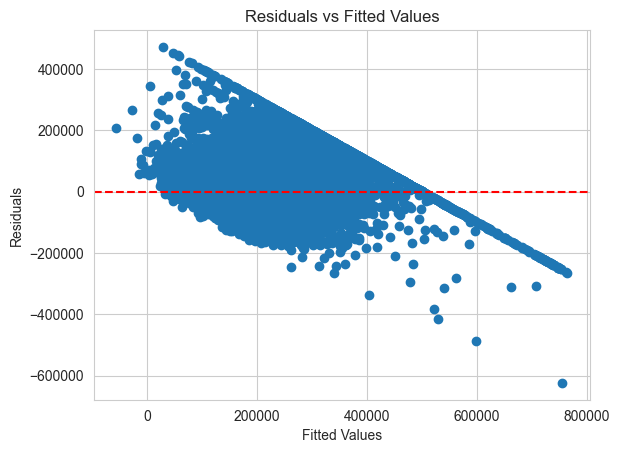

In [63]:
my_resid = result.resid
my_fitted = result.fittedvalues

# Create scatter plot
plt.scatter(my_fitted, my_resid)
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

### Use ncvTest or equivalent to test for heteroscedasticity

In [64]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)
if lm_p_value < 0.05:
    print("Reject the null hypothesis: The residuals are heteroscedastic")
else:
    print("Fail to reject the null hypothesis: The residuals are homoscedastic")

Lagrange multiplier statistic: 524.6677405571374
p-value for Lagrange multiplier test: 4.072278140202884e-110
F-statistic: 89.71840809298067
p-value for F-statistic: 1.44834794232938e-111
Reject the null hypothesis: The residuals are heteroscedastic


### Test for normality of the residuals 

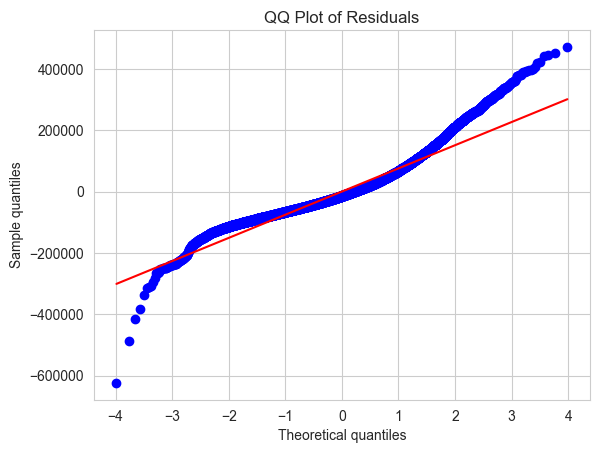

The QQ plot shows that the residuals are not normally distributed as there is significant deviation from the straight line
Shapiro-Wilk test statistic: 0.9272986467549998
Shapiro-Wilk test p-value: 2.2236948379166963e-70
Reject the null hypothesis: The residuals are not normally distributed


In [65]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()
print("The QQ plot shows that the residuals are not normally distributed as there is significant deviation from the straight line")

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

### Method 2 : Model 2 - Linear Regression

In [66]:
f2 = 'median_house_value ~ latitude + housing_median_age + total_bedrooms + population + median_income + ocean_proximity'
model = sm.formula.ols(formula=f2, data=df)
result = model.fit()
r2 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4331.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:39:15   Log-Likelihood:            -2.5878e+05
No. Observations:               20433   AIC:                         5.176e+05
Df Residuals:                   20426   BIC:                         5.176e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.898e+05   1.01

### Check for collinearity using VIF to remove highly correlated variables from the models

In [67]:
features_r2 = ['latitude', 'housing_median_age', 'total_bedrooms', 'population', 'median_income', 'ocean_proximity']
X_r2 = df[features_r2]
vif_data_f2 = pd.DataFrame()
vif_data_f2["Feature"] = X_r2.columns
vif_data_f2["VIF"] = [variance_inflation_factor(X_r2.values, i) for i in range(len(X_r2.columns))]
print(vif_data_f2)

              Feature        VIF
0            latitude  16.080752
1  housing_median_age   6.770386
2      total_bedrooms  11.855771
3          population  11.424867
4       median_income   5.053225
5     ocean_proximity   1.958643


##### To address collinearity, we utilized the Variance Inflation Factor (VIF) to detect multicollinearity. A VIF value above 5 suggests significant multicollinearity within the model, indicating the need for further adjustments.

##### A VIF exceeding 5 presents a potential issue. Therefore, in our scenario, we could address multicollinearity by eliminating 'latitude' and 'total_bedrooms', as they exhibit high correlation with each other.

In [68]:
# remove total_bedrooms and latitude from the model
f2_modified = 'median_house_value ~ housing_median_age + population + median_income + ocean_proximity'
model_modified = sm.formula.ols(formula=f2_modified, data=df)
result_modified = model_modified.fit()
print(result_modified.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     5336.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:39:15   Log-Likelihood:            -2.5986e+05
No. Observations:               20433   AIC:                         5.197e+05
Df Residuals:                   20428   BIC:                         5.198e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.925e+04   2292

In [69]:
features_modified_r2 = ['housing_median_age', 'population', 'median_income', 'ocean_proximity']
X_modified_r2 = df[features_modified_r2]
vif_data_f2_modified = pd.DataFrame()
vif_data_f2_modified["Feature"] = X_modified_r2.columns
vif_data_f2_modified["VIF"] = [variance_inflation_factor(X_modified_r2.values, i) for i in range(len(X_modified_r2.columns))]
print(vif_data_f2_modified)

              Feature       VIF
0  housing_median_age  3.343534
1          population  2.060304
2       median_income  3.398471
3     ocean_proximity  1.804031


### Plot the distribution of the residuals against the fitted values to check for heteroscedasticity

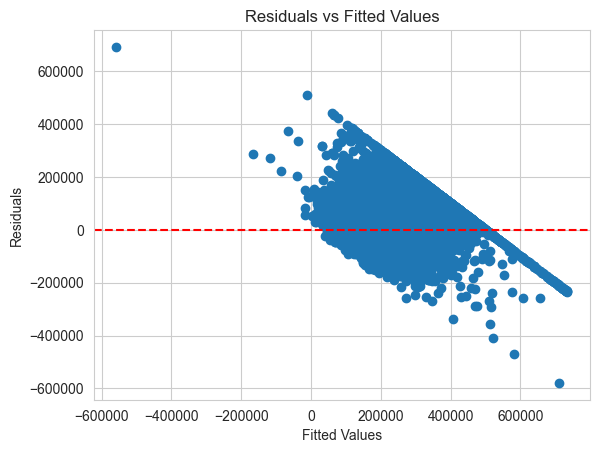

In [70]:
my_resid = result.resid
my_fitted = result.fittedvalues
plt.scatter(my_fitted, my_resid)
plt.title("Residuals vs Fitted Values")
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

### Use ncvTest or equivalent to test for heteroscedasticity

In [71]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)
if f_p_value < 0.05:
    print("Reject the null hypothesis: The residuals are heteroscedastic")
else:
    print("Fail to reject the null hypothesis: The residuals are homoscedastic")

Lagrange multiplier statistic: 530.6731971347514
p-value for Lagrange multiplier test: 2.0683175636826215e-111
F-statistic: 90.77272582280787
p-value for F-statistic: 6.800513636592252e-113
Reject the null hypothesis: The residuals are heteroscedastic


### Test for normality of the residuals 

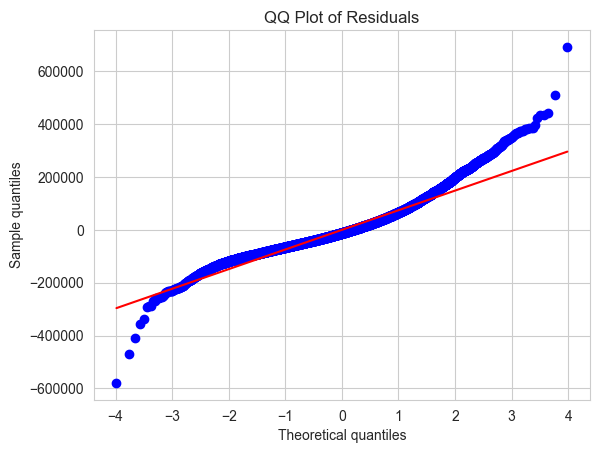

QQ plot shows that the residuals are not normally distributedas as there is significant deviation from the straight line
Shapiro-Wilk test statistic: 0.9411884248471788
Shapiro-Wilk test p-value: 5.356357568529892e-66
Reject the null hypothesis: The residuals are not normally distributed


In [72]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()
print("QQ plot shows that the residuals are not normally distributedas as there is significant deviation from the straight line")

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

### Method 3 : Model 3 - Linear Regression

In [73]:
f3 = 'median_house_value ~ median_income + ocean_proximity'
model = sm.formula.ols(formula=f3, data=df)
result = model.fit()
r3 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     9284.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:39:16   Log-Likelihood:            -2.6056e+05
No. Observations:               20433   AIC:                         5.211e+05
Df Residuals:                   20430   BIC:                         5.212e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.944e+04   1446.851     

### Check for collinearity using VIF to remove highly correlated variables from the models

In [74]:
features_r3 = ['median_income', 'ocean_proximity']
X_r3 = df[features_r3]
vif_data_r3 = pd.DataFrame()
vif_data_r3["Feature"] = X_r3.columns
vif_data_r3["VIF"] = [variance_inflation_factor(X_r3.values, i) for i in range(len(X_r3.columns))]
print(vif_data_r3)

           Feature       VIF
0    median_income  1.533143
1  ocean_proximity  1.533143


Based on the Variance Inflation Factor (VIF) results:

- **median_income VIF:** 1.533248
- **ocean_proximity VIF:** 1.533248

These VIF values suggest that there is low multicollinearity between `median_income` and `ocean_proximity` in the model. Therefore, the coefficient estimates for these features are likely to be stable and reliable.


### Plot the distribution of the residuals against the fitted values to check for heteroscedasticity

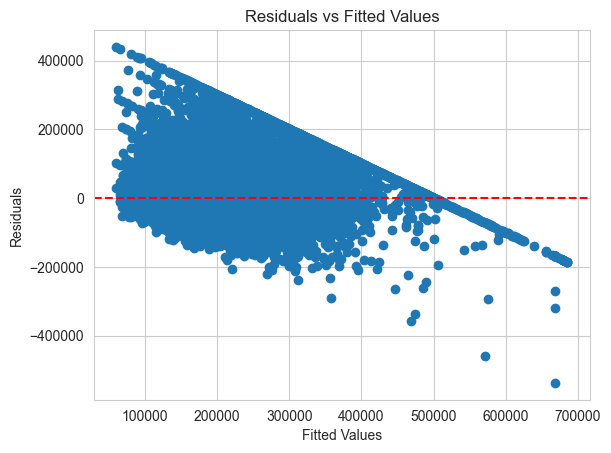

In [75]:
my_resid = result.resid
my_fitted = result.fittedvalues

# Create scatter plot
plt.scatter(my_fitted, my_resid)
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

### Use ncvTest or equivalent to test for heteroscedasticity

In [76]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)
if f_p_value < 0.05:
    print("Reject the null hypothesis: The residuals are heteroscedastic")
else:
    print("Fail to reject the null hypothesis: The residuals are homoscedastic")

Lagrange multiplier statistic: 226.87966596005964
p-value for Lagrange multiplier test: 5.416347361221146e-50
F-statistic: 114.69672304572661
p-value for F-statistic: 2.920264876709513e-50
Reject the null hypothesis: The residuals are heteroscedastic


### Test for normality of the residuals 

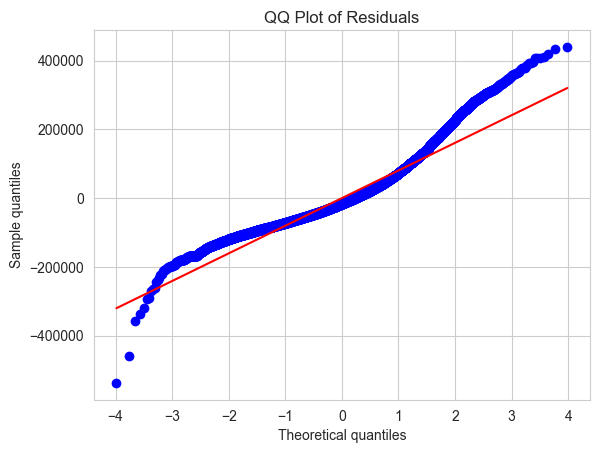

The QQ plot shows that residuals are not normally distributed
Shapiro-Wilk test statistic: 0.9249935218597345
Shapiro-Wilk test p-value: 4.895215527698028e-71
Reject the null hypothesis: The residuals are not normally distributed


In [77]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()
print("The QQ plot shows that residuals are not normally distributed")

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

### Method - 4: Multiple Linear Regression

The mean squared error is:  4836130919.857884


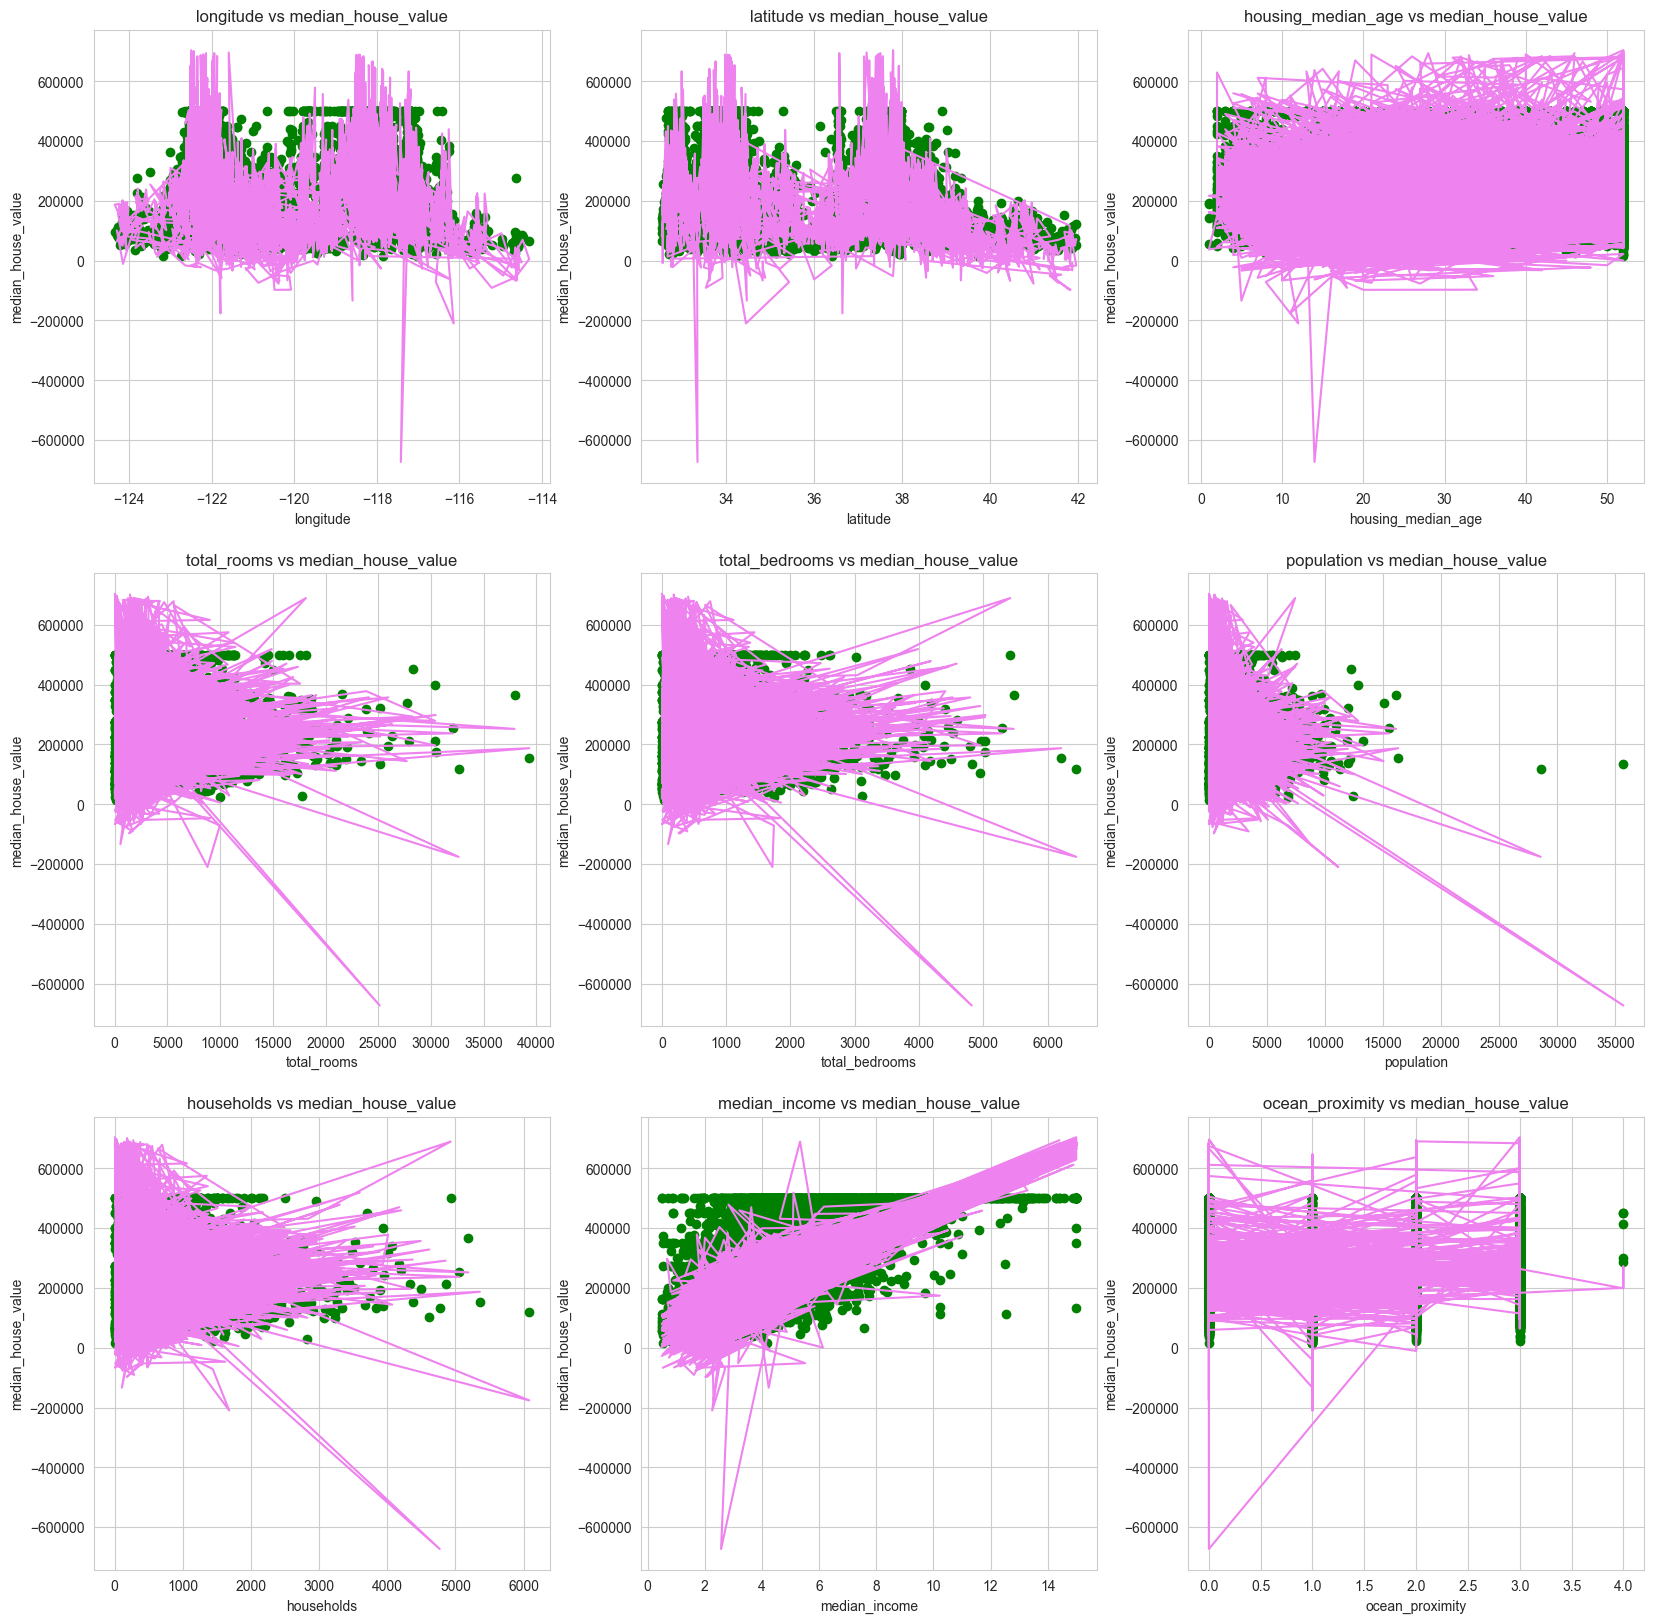

In [78]:
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

mse = mean_squared_error(y_pred, y)
print("The mean squared error is: ", mse)

plt.figure(figsize=(20, 20))
for i in range(0, len(df_2.columns)):
    plt.subplot(3, 3, i+1)
    plt.scatter(df_2.iloc[:, i], y, color='green')
    plt.plot(df_2.iloc[:, i], y_pred, color='violet')
    plt.xlabel(df_2.columns[i])
    plt.ylabel('median_house_value')
    plt.title(df_2.columns[i]+' vs median_house_value')

### Plot the distribution of the residuals against the fitted values to check for heteroscedasticity

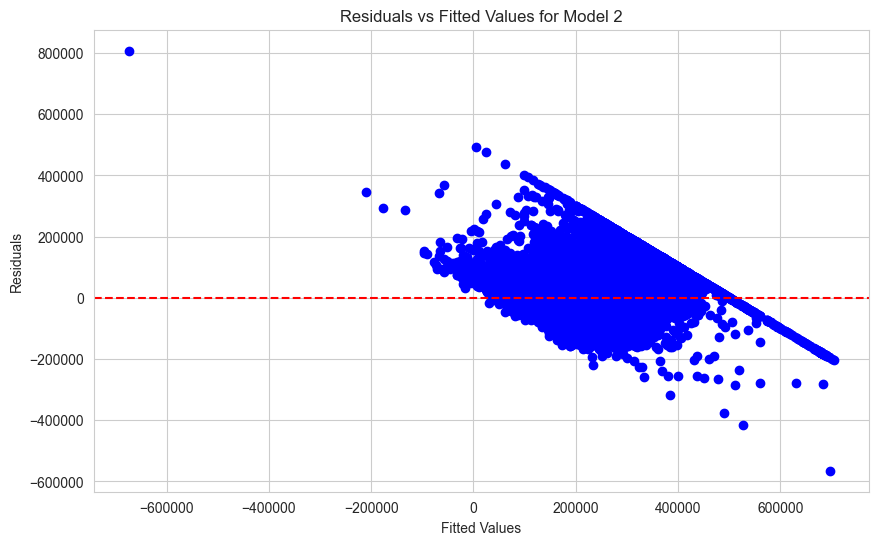

In [79]:
residuals = y - y_pred
mse = mean_squared_error(y_pred, y)

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Model 2')
plt.show()

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = df_2.columns
vif_data["VIF"] = [variance_inflation_factor(df_2.values, i) for i in range(len(df_2.columns))]

### Check for collinearity using VIF to remove highly correlated variables from the models

In [81]:
X = df_2
for i in range(0,5):
    max_vif_index = vif_data['VIF'].idxmax()
    X = X.drop(vif_data['feature'][max_vif_index], axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
df_vif = X
print("The final values are as follows: ")
print(vif_data)

The final values are as follows: 
              feature       VIF
0  housing_median_age  3.343534
1          population  2.060304
2       median_income  3.398471
3     ocean_proximity  1.804031


##### VIF is used to check multicollinearity, so if VIF is above 5 then it indicates high multicollinearity

##### Overall, the VIF values indicate that while there is some degree of collinearity among the predictors, it is not severe enough to cause significant multicollinearity issues.

##### The variables "population" and "ocean_proximity" have relatively low VIF values, suggesting they are less correlated with other predictors in the model.

##### The variables "housing_median_age" and "median_income" have slightly higher VIF values, indicating a moderate degree of collinearity, but it's still within an acceptable range.

##### These results suggest that the selected predictors may be suitable for inclusion in a linear regression model without significant multicollinearity concerns. However, it's always important to consider the context of the analysis and interpret the results accordingly.

##### We get the conclusion that there is no constant variance despite the fact that constant variance is supposed to be necessary for regression because of the uneven distribution of the residuals. Consequently, heteroscedasticity exists. 

### Use ncvTest or equivalent to test for heteroscedasticity

In [82]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
X_with_const = sm.add_constant(X)
ncv_test_result = het_breuschpagan(residuals, X_with_const,robust='hc1')
p_value_ncv_test = ncv_test_result[1]
print("The p-value of the Breusch-Pagan test with sandwich estimator is: ", p_value_ncv_test)

The p-value of the Breusch-Pagan test with sandwich estimator is:  2.055647465694922e-71


Since the p-value for each test is less than 0.05, we may say that the data are heteroscedastic.

##### Since the p-value is much smaller than any reasonable significance level (e.g., 0.05), we reject the null hypothesis of homoscedasticity. Therefore, we conclude that there is strong evidence of heteroscedasticity in the residuals of the linear regression model.

##### Implications: Heteroscedasticity violates one of the assumptions of linear regression, which is that the residuals should have constant variance. In the presence of heteroscedasticity, the standard errors of the estimated coefficients may be biased, leading to incorrect inferences about the statistical significance of the regression coefficients.

### Test for normality of the residuals 

QQ plot for Model 5: 


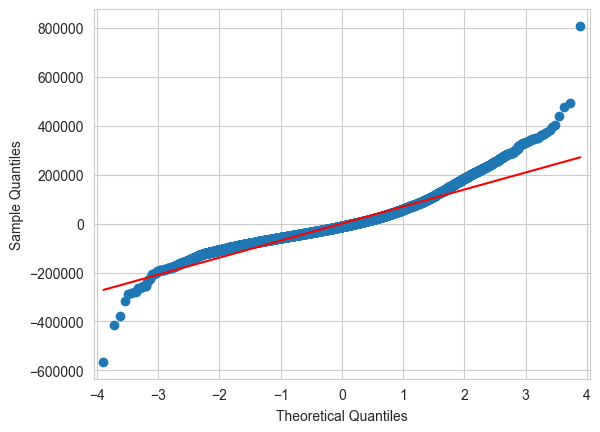

Shapiro-Wilk test statistic: 0.9274488727533661
Shapiro-Wilk test p-value: 2.4576604934922958e-70
Reject the null hypothesis: The residuals are not normally distributed


In [83]:
print("QQ plot for Model 5: ")
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
sm.qqplot(residuals, line='s')
plt.show()

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

As indicated by Q-Q plot, the residuals are not normally distributed

## Compare the models using AIC and pick the best model.

In [84]:
import statsmodels.api as sm

print("AIC for Model 1: ",r1.aic)
print("AIC for Model 2: ",r2.aic)
print("AIC for Model 3: ",r3.aic)
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
X = df_2
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

AIC for Model 1:  518565.1549452875
AIC for Model 2:  517581.1228506882
AIC for Model 3:  521134.05610143853


#### Model 2 has a lower AIC and hence performs better 

## Report the coefficients of the winning model and their statistics

In [85]:
f2 = 'median_house_value ~ latitude + housing_median_age + total_bedrooms + population + median_income + ocean_proximity'
model = sm.formula.ols(formula=f2, data=df)
result = model.fit()
r2 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4331.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:39:19   Log-Likelihood:            -2.5878e+05
No. Observations:               20433   AIC:                         5.176e+05
Df Residuals:                   20426   BIC:                         5.176e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.898e+05   1.01

In [86]:
print("Confidence intervals for Model 2: 95% confidence level")
print(result.conf_int())

Confidence intervals for Model 2: 95% confidence level
                                0              1
Intercept           169995.593274  209638.318905
latitude             -6838.221340   -5759.644831
housing_median_age    1914.906131    2094.933879
total_bedrooms         108.034795     118.625611
population             -36.227536     -32.316174
median_income        42687.730613   43806.770791
ocean_proximity       3849.802047    6163.646528


## Interpret the resulting model coefficients

**Summary of Regression Analysis:**

- **R-squared:** 0.560, indicating the model explains approximately 56.0% of the variation in the response variable.
- **Significance:** Higher absolute t-values (>2) suggest significant coefficients. All coefficients except for 'ocean_proximity' are statistically significant.
- **Adjusted R-squared:** Consistent with R-squared at 0.560.
- **Model Fit:** F-statistic of 4331 with p-value 0.00 suggests a highly significant overall model fit.
- **Interpretations:** Notable coefficients include 'latitude' ($-6299.04), 'housing_median_age' ($2004.89), 'total_bedrooms' ($113.33), 'population' ($-34.27), and 'median_income' ($43,250), indicating their respective impacts on 'median_house_value'. 'ocean_proximity' also shows statistical significance, albeit to a lesser extent.

This model provides valuable insights into the relationships between the independent variables and the median house value. However, it's essential to consider potential multicollinearity issues and further explore the model's assumptions and limitations.


# PART 2

In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [88]:
data = pd.read_csv('binary.csv')
data = data.dropna()
# min-max scaling is not necessary for logistic regression
X = data[['gre', 'gpa', 'rank']]
y = data['admit']

##  Significant Variables Predicting Admission

In [89]:
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print("Parameters:")
print(result.params)
print("\nSummary:")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.565088
         Iterations 6
Parameters:
const   -3.400466
gre      0.001725
gpa      0.891067
rank    -0.615949
dtype: float64

Summary:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                            3
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                 0.09016
Time:                        16:39:20   Log-Likelihood:                -180.83
converged:                       True   LL-Null:                       -198.75
Covariance Type:            nonrobust   LLR p-value:                 8.100e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

## Statistics and Interpretation:

**Pseudo R-squared:** The Pseudo R-squared value is 0.09016. This value represents the proportion of variance explained by the model. A higher value indicates a better fit of the model to the data.

**Coefficients:**

- **GRE:** The coefficient for GRE is 0.0017. This indicates that for a one-unit increase in GRE score, the log-odds of being admitted increases by 0.0017, holding other variables constant.
- **GPA:** The coefficient for GPA is 0.8911. This indicates that for a one-unit increase in GPA, the log-odds of being admitted increases by 0.8911, holding other variables constant.
- **Rank:** The coefficient for rank is -0.6159. This indicates that for a one-unit increase in rank (i.e., higher rank), the log-odds of being admitted decreases by 0.6159, holding other variables constant.

**Significance:**

- The coefficient for GRE has a p-value of 0.158, which is greater than the typical significance level of 0.05. Therefore, GRE may not be statistically significant in predicting admission at this significance level.
- The coefficient for GPA has a p-value of 0.016, which is less than 0.05. Therefore, GPA is statistically significant in predicting admission at the 0.05 significance level.
- The coefficient for rank has a p-value of <0.001, indicating that it is highly statistically significant in predicting admission.

## Interpretation of Results:

The most significant variable that predicts whether someone will get admitted is the rank of the undergraduate institution, as it has the lowest p-value (<0.001).

In summary, according to this logistic regression model, GPA and the rank of the undergraduate institution are significant predictors of admission, while GRE may not be statistically significant in this context.




#### Both GPA and Rank are more significant variables for predicting the chance of admission. The p-values for both variables are less than 0.05, indicating a significant relationship with the response variable. The coefficients for both variables are positive, suggesting that higher GPA and Rank are associated with a higher chance of admission.

##### The most significant variable that predicts whether someone will get admitted is the rank of the undergraduate institution, as it has the lowest p-value (<0.001).

## Interpretation in Terms of Odds Ratios and Confidence Intervals:

In [90]:
print("Confidence Intervals with 95% confidence level:")
conf_intervals = result.conf_int()
for i in range(len(conf_intervals)):
    print(f"Variable: {conf_intervals.index[i]}, Confidence Interval: {tuple(conf_intervals.iloc[i])}")

Confidence Intervals with 95% confidence level:
Variable: const, Confidence Interval: (-5.925518269248789, -0.8754146079120262)
Variable: gre, Confidence Interval: (-0.0006707634583183314, 0.0041209017978231875)
Variable: gpa, Confidence Interval: (0.16371746162548495, 1.6184156274951733)
Variable: rank, Confidence Interval: (-0.8964668167752332, -0.3354321184430738)


In [91]:
print("Odds ratios:")
print(np.exp(result.params))

Odds ratios:
const    0.033358
gre      1.001727
gpa      2.437728
rank     0.540128
dtype: float64


**Interpretation of Odds Ratios:**

- **GRE:** For each one-unit increase in GRE score, the odds of being admitted increase by approximately 1.0017 times, holding other variables constant.
- **GPA:** For each one-unit increase in GPA, the odds of being admitted increase by approximately 2.4377 times, holding other variables constant.
- **Rank:** For each one-unit increase in rank (i.e., higher rank), the odds of being admitted decrease by approximately 0.5401 times, holding other variables constant.
- **Constant (Intercept):** The odds of being admitted when all other variables are zero is approximately 0.0334.


In [92]:
y_pred = result.predict(X_test)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Confusion Matrix:
[[49  4]
 [23  4]]
Accuracy: 0.6625


## Testing Interaction Effect

In [93]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data['gpa_rank_interaction'] = data['gpa']*data['rank']
X = data[['gre', 'gpa', 'rank', 'gpa_rank_interaction']]
y = data['admit']
X = sm.add_constant(X)
X['gpa_rank_interaction'] = X['gpa']*X['rank']
y = data['admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logit_model = sm.Logit(y_train, X_train)

### Logit Model with Interaction Term:

In [94]:
result = logit_model.fit()
print("Parameters:")
print(result.params)

Optimization terminated successfully.
         Current function value: 0.565088
         Iterations 6
Parameters:
const                  -3.343342
gre                     0.001724
gpa                     0.874755
rank                   -0.641493
gpa_rank_interaction    0.007380
dtype: float64


In [95]:
print("\nSummary:")
print(result.summary())


Summary:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      315
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                 0.09016
Time:                        16:39:20   Log-Likelihood:                -180.83
converged:                       True   LL-Null:                       -198.75
Covariance Type:            nonrobust   LLR p-value:                 3.123e-07
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.3433      3.375     -0.991      0.322      -9.958       3.271
gre                      0.0017      0.001      1.409      0.159      -0.001       0.004
gp

**Interaction Effect in the Logit Regression Model**

The model includes an interaction term (`gpa_rank_interaction`) to assess whether the effect of GPA on admission likelihood depends on a student's rank.

* **Coefficient:** 0.0074
* **Statistical Significance:** The p-value of the interaction term is 0.985, indicating that the interaction effect is not statistically significant.

**Interpretation:**

We don't have enough evidence to conclude that the relationship between GPA and the probability of admission is different for students of varying ranks. 

1. Coefficient of gpa_rank is in between gpa and rank.
2. The influence of gpa on the likelihood of admission varies depending on rank.
For example, the influence of gpa on the chance of admission varies depending on rank.

In [96]:
y_pred = result.predict(X_test)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Confusion Matrix:
[[49  4]
 [23  4]]
Accuracy: 0.6625


### Binomial Logistic Regression Model with Interaction Term:

In [97]:
data['gpa_times_rank'] = data['gpa'] * data['rank']
X_interaction = data[['gre', 'gpa', 'rank', 'gpa_times_rank']]
X_interaction = sm.add_constant(X_interaction)
result_interaction = sm.GLM(y, X_interaction, family=sm.families.Binomial()).fit()
print("\nSummary of Logistic Regression with Interaction:")
print(result_interaction.summary())


Summary of Logistic Regression with Interaction:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      395
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -229.67
Date:                Fri, 12 Apr 2024   Deviance:                       459.33
Time:                        16:39:20   Pearson chi2:                     399.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09661
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [98]:
coefficients_interaction = result_interaction.params
odds_ratios_interaction = np.exp(coefficients_interaction)
print("\nInterpretation of Coefficients for Interaction:")
for idx, coef in enumerate(coefficients_interaction.index):
    print(f"{coef}: {odds_ratios_interaction.iloc[idx]}")
y_pred_interaction = result_interaction.predict(X_interaction)
y_pred_binary_interaction = (y_pred_interaction >= 0.5).astype(int)
accuracy_interaction = (y_pred_binary_interaction == y).mean()
print(f"\nAccuracy with Interaction Term: {accuracy_interaction}")


Interpretation of Coefficients for Interaction:
const: 0.012975552789498572
gre: 1.002302650667668
gpa: 2.819758557078446
rank: 0.8458380539520747
gpa_times_rank: 0.8920576362589989

Accuracy with Interaction Term: 0.705


**Summary of Interpretations from Binomial Logistic Regression with Interaction:**

- **GRE:** Each one-unit increase in GRE score is associated with a 0.23% increase in the odds of admission.

- **GPA:** Each one-unit increase in GPA is associated with more than doubling (117.5% increase) in the odds of admission.

- **Rank:** Each one-unit decrease in rank (moving to a higher-ranked institution) is associated with a 42.9% decrease in the odds of admission.

- **Interaction Term (GPA * Rank):**
  - **Coefficient:** -0.1142
  - **Interpretation:** The interaction between GPA and rank suggests that the effect of GPA on admission varies depending on the rank of the undergraduate institution.
  - **Odds Ratio:** exp(-0.1142) = 0.892
  - **Inference:** For each unit increase in the product of GPA and rank, the odds of admission decrease by a factor of 0.892. This indicates that as the rank of the institution increases, the positive impact of GPA on admission diminishes.

**Summary of Logistic Regression with Interaction:**

- **Model Fit:**
  - Pseudo R-squared (CS): 0.09661, indicating that the model explains approximately 9.66% of the variation in the response variable.
  - Deviance: 459.33
  - Pearson chi2: 399.
  - No. Iterations: 4

- **Interpretation of Coefficients:**
  - The coefficients for GRE, GPA, and the interaction term (GPA_times_rank) are not statistically significant (p > 0.05).
  - The coefficient for rank is also not statistically significant.
  - These results suggest that none of the predictor variables have a significant impact on admission status in this model.

This logistic regression model with interaction does not provide strong evidence of significant predictors for admission status, as indicated by the non-significant coefficients and relatively low pseudo R-squared value.
